In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# =========================
# 1. Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])
df_city = df[df['city'] == 'Warszawa'][['time', 'temp']]
df_city.sort_values("time", inplace=True)

# =========================
# 2. Tworzenie sekwencji multi-step
# =========================
WINDOW = 60
FORECAST = 5

def create_sequences(df, window=WINDOW, forecast_horizon=FORECAST):
    X, y = [], []
    for i in range(len(df) - window - forecast_horizon + 1):
        X.append(df.iloc[i:i+window]['temp'].values)
        y.append(df.iloc[i+window:i+window+forecast_horizon]['temp'].values)
    return np.array(X), np.array(y)

X, y = create_sequences(df_city)

# =========================
# 3. Skalowanie danych
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X.reshape(-1,1)).reshape(X.shape)
y_scaled = scaler_y.fit_transform(y)
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# =========================
# 4. Walk-forward cross-validation
# =========================
tscv = TimeSeriesSplit(n_splits=5)

rmse_scores = []
mae_scores = []
mse_scores = []
r2_scores = []

fold = 1
for train_index, val_index in tscv.split(X_scaled):
    print(f"\n--- Fold {fold} ---")
    
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y_scaled[train_index], y_scaled[val_index]
    
    # =========================
    # Budowa modelu LSTM+GRU
    # =========================
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(WINDOW,1)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(FORECAST))
    model.compile(optimizer='adam', loss='mse')
    
    # =========================
    # EarlyStopping
    # =========================
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # =========================
    # Trenowanie
    # =========================
    model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stop],
        verbose=0
    )
    
    # =========================
    # Predykcja i metryki
    # =========================
    y_pred_scaled = model.predict(X_val)
    
    y_val_rescaled = scaler_y.inverse_transform(y_val)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)
    
    mse  = mean_squared_error(y_val_rescaled, y_pred_rescaled)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_val_rescaled, y_pred_rescaled)
    r2   = r2_score(y_val_rescaled, y_pred_rescaled)
    
    print(f"Fold {fold} - R²: {r2:.4f} | MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    
    fold += 1

# =========================
# 5. Średnie metryki po wszystkich foldach
# =========================
print("\nWalk-Forward Cross-Validation — LSTM+GRU")
print(f"R²   : {np.mean(r2_scores):.4f}")
print(f"MAE  : {np.mean(mae_scores):.4f}")
print(f"MSE  : {np.mean(mse_scores):.4f}")
print(f"RMSE : {np.mean(rmse_scores):.4f}")



--- Fold 1 ---


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fold 1 - R²: 0.6929 | MAE: 3.5989 | MSE: 19.6715 | RMSE: 4.4353

--- Fold 2 ---


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Fold 2 - R²: 0.7504 | MAE: 3.1564 | MSE: 15.8880 | RMSE: 3.9860

--- Fold 3 ---


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fold 3 - R²: 0.7886 | MAE: 3.0572 | MSE: 14.7236 | RMSE: 3.8371

--- Fold 4 ---


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Fold 4 - R²: 0.7888 | MAE: 2.8638 | MSE: 13.3557 | RMSE: 3.6546

--- Fold 5 ---


C:\Users\gduls\PycharmProjects\pythonProject10\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
Fold 5 - R²: 0.7768 | MAE: 2.9884 | MSE: 14.3002 | RMSE: 3.7816

Walk-Forward Cross-Validation — LSTM+GRU
R²   : 0.7595
MAE  : 3.1330
MSE  : 15.5878
RMSE : 3.9389


XGBoost Multi-step Forecast — 5 dni (jednym rzutem)
R²   : 0.7906
MAE  : 2.7674
MSE  : 13.0788
RMSE : 3.6165


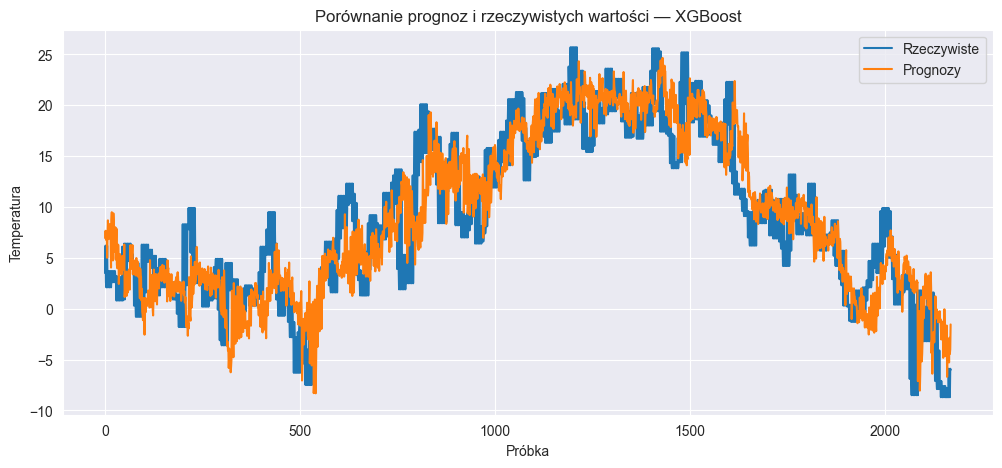

Prognoza 5 dni do przodu (XGBoost jednorazowo):
2026-01-15: -5.28 °C
2026-01-16: -2.86 °C
2026-01-17: -4.45 °C
2026-01-18: -4.00 °C
2026-01-19: -1.55 °C


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])
df_city = df[df['city'] == 'Warszawa'].copy()
df_city.sort_values("time", inplace=True)
df_city.reset_index(drop=True, inplace=True)

# =========================
# 2. Parametry
# =========================
WINDOW = 30
FORECAST = 5

# =========================
# 3. Tworzenie cech historycznych + sezonowych
# =========================
def create_features(df, window=WINDOW):
    X, y = [], []
    for i in range(window, len(df) - FORECAST + 1):
        hist = df['temp'].iloc[i-window:i].values.tolist()
        dayofyear = df['time'].iloc[i].dayofyear
        month = df['time'].iloc[i].month
        last7 = df['temp'].iloc[i-7:i].values
        avg7 = np.mean(last7)
        min7 = np.min(last7)
        max7 = np.max(last7)
        features = hist + [dayofyear, month, avg7, min7, max7]
        X.append(features)
        y.append(df['temp'].iloc[i:i+FORECAST].values)
    return np.array(X), np.array(y)

X, y = create_features(df_city)

# =========================
# 4. Skalowanie
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)  # multi-output (n_samples, 5)

# =========================
# 5. Train/test split
# =========================
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# =========================
# 6. Trening MultiOutputRegressor (5 dni naraz)
# =========================
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
model = MultiOutputRegressor(xgb)
model.fit(X_train, y_train)

# =========================
# 7. Predykcja na zbiorze testowym
# =========================
y_pred_scaled = model.predict(X_test)
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)

# =========================
# 8. Metryki
# =========================
mse  = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2   = r2_score(y_test_rescaled, y_pred_rescaled)

print("XGBoost Multi-step Forecast — 5 dni (jednym rzutem)")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")

# =========================
# 9. Wykres rzeczywiste vs prognozy
# =========================
plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled.flatten(), label='Rzeczywiste')
plt.plot(y_pred_rescaled.flatten(), label='Prognozy')
plt.title("Porównanie prognoz i rzeczywistych wartości — XGBoost")
plt.xlabel("Próbka")
plt.ylabel("Temperatura")
plt.legend()
plt.show()

# =========================
# 10. Prognoza 5 dni do przodu od ostatniego dnia w danych
# =========================
last_window = X_scaled[-1].reshape(1,-1)
future_scaled = model.predict(last_window)
future_pred = scaler_y.inverse_transform(future_scaled)

# =========================
# 11. Wypisanie prognoz
# =========================
print("Prognoza 5 dni do przodu (XGBoost jednorazowo):")
for i, pred in enumerate(future_pred.flatten(), 1):
    pred_date = df_city['time'].iloc[-1] + pd.Timedelta(days=i)
    print(f"{pred_date.date()}: {pred:.2f} °C")


XGBoost Multi-step Forecast — 5 dni (jednym rzutem) z ulepszonymi cechami
R²   : 0.7632
MAE  : 2.2445
MSE  : 8.3938
RMSE : 2.8972


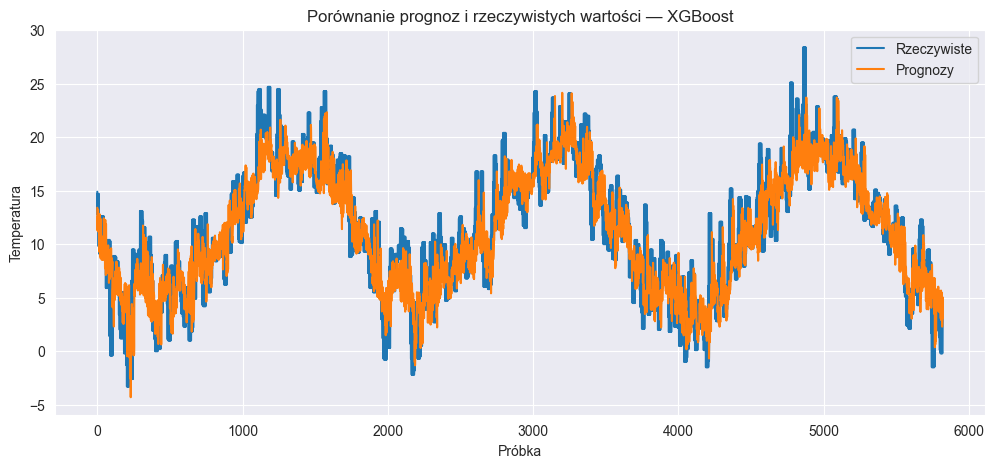

Prognoza 5 dni do przodu (XGBoost jednorazowo):
2026-01-10: 2.30 °C
2026-01-11: 4.07 °C
2026-01-12: 4.27 °C
2026-01-13: 5.04 °C
2026-01-14: 3.06 °C


In [8]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import math

# =========================
# 1. Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean.csv", parse_dates=["date"])
df_city = df[df['city'] == 'Warszawa'].copy()
df_city.sort_values("date", inplace=True)
df_city.reset_index(drop=True, inplace=True)

# =========================
# 2. Parametry
# =========================
WINDOW = 30
FORECAST = 5

# =========================
# 3. Tworzenie cech historycznych + sezonowych + statystycznych
# =========================
def create_features(df, window=WINDOW):
    X, y = [], []
    for i in range(window, len(df) - FORECAST + 1):
        hist = df['tavg'].iloc[i-window:i].values.tolist()
        
        # statystyki okna
        mean_hist = np.mean(hist)
        min_hist = np.min(hist)
        max_hist = np.max(hist)
        std_hist = np.std(hist)
        diff_mean = np.mean(np.diff(hist))
        
        # cechy sezonowe
        date_i = df['date'].iloc[i]
        dayofyear_sin = math.sin(2*math.pi*date_i.dayofyear/365)
        dayofyear_cos = math.cos(2*math.pi*date_i.dayofyear/365)
        month = date_i.month
        
        # cechy ostatnich 7 dni
        last7 = df['tavg'].iloc[i-7:i].values
        avg7 = np.mean(last7)
        min7 = np.min(last7)
        max7 = np.max(last7)
        
        features = hist + [mean_hist, min_hist, max_hist, std_hist, diff_mean,
                           dayofyear_sin, dayofyear_cos, month,
                           avg7, min7, max7]
        X.append(features)
        y.append(df['tavg'].iloc[i:i+FORECAST].values)
    return np.array(X), np.array(y)

X, y = create_features(df_city)

# =========================
# 4. Skalowanie
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)  # multi-output (n_samples, 5)

# =========================
# 5. Train/test split
# =========================
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# =========================
# 6. Trening MultiOutputRegressor (5 dni naraz)
# =========================
xgb = XGBRegressor(
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
model = MultiOutputRegressor(xgb)
model.fit(X_train, y_train)

# =========================
# 7. Predykcja na zbiorze testowym
# =========================
y_pred_scaled = model.predict(X_test)
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)

# =========================
# 8. Metryki
# =========================
mse  = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2   = r2_score(y_test_rescaled, y_pred_rescaled)

print("XGBoost Multi-step Forecast — 5 dni (jednym rzutem) z ulepszonymi cechami")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")

# =========================
# 9. Wykres rzeczywiste vs prognozy
# =========================
plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled.flatten(), label='Rzeczywiste')
plt.plot(y_pred_rescaled.flatten(), label='Prognozy')
plt.title("Porównanie prognoz i rzeczywistych wartości — XGBoost")
plt.xlabel("Próbka")
plt.ylabel("Temperatura")
plt.legend()
plt.show()

# =========================
# 10. Prognoza 5 dni do przodu od ostatniego dnia w danych
# =========================
last_window = X_scaled[-1].reshape(1,-1)
future_scaled = model.predict(last_window)
future_pred = scaler_y.inverse_transform(future_scaled)

# =========================
# 11. Wypisanie prognoz
# =========================
print("Prognoza 5 dni do przodu (XGBoost jednorazowo):")
for i, pred in enumerate(future_pred.flatten(), 1):
    pred_date = df_city['date'].iloc[-1] + pd.Timedelta(days=i)
    print(f"{pred_date.date()}: {pred:.2f} °C")


00:44:50 - cmdstanpy - INFO - Chain [1] start processing
00:44:51 - cmdstanpy - INFO - Chain [1] done processing


Prognoza 5 dni do przodu (Prophet z regresorami):
2026-01-15: -4.83 °C
2026-01-16: -3.48 °C
2026-01-17: -2.57 °C
2026-01-18: -2.15 °C
2026-01-19: -1.75 °C


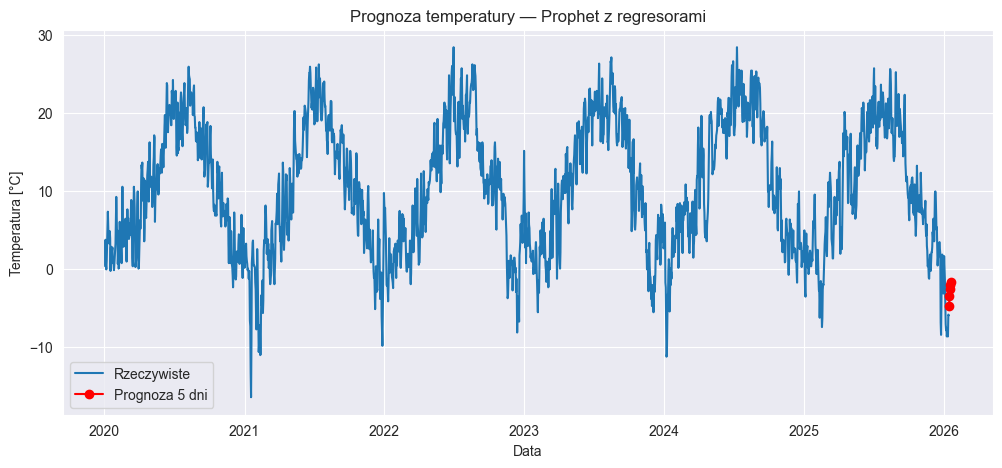

In [4]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])
df_city = df[df['city'] == 'Warszawa'][['time','temp']].copy()
df_city.sort_values("time", inplace=True)
df_city.reset_index(drop=True, inplace=True)

# =========================
# 2. Przygotowanie danych dla Prophet
# =========================
# Prophet wymaga kolumn 'ds' (data) i 'y' (wartość)
prophet_df = df_city.rename(columns={'time':'ds', 'temp':'y'})

# Dodanie regresorów: temperatura z 1, 2 i 3 dni wstecz
for lag in [1,2,3]:
    prophet_df[f'lag_{lag}'] = prophet_df['y'].shift(lag)
prophet_df = prophet_df.dropna().reset_index(drop=True)

# =========================
# 3. Tworzenie i trenowanie modelu
# =========================
model = Prophet(daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)

# Dodanie regresorów do Prophet
for lag in [1,2,3]:
    model.add_regressor(f'lag_{lag}')

# Trenowanie modelu
model.fit(prophet_df)

# =========================
# 4. Iteracyjna prognoza 5 dni do przodu
# =========================
future_dates = []
future_preds = []
last_known = prophet_df.tail(3)['y'].tolist()  # trzy ostatnie dni jako lag

for i in range(5):
    # nowy dzień
    next_date = prophet_df['ds'].iloc[-1] + pd.Timedelta(days=i+1)
    row = pd.DataFrame({
        'ds':[next_date],
        'lag_1':[last_known[-1]],
        'lag_2':[last_known[-2]],
        'lag_3':[last_known[-3]]
    })
    pred = model.predict(row)
    yhat = pred['yhat'].values[0]
    
    future_dates.append(next_date)
    future_preds.append(yhat)
    
    # aktualizacja lagów
    last_known.append(yhat)
    last_known = last_known[-3:]  # trzy ostatnie dni

# =========================
# 5. Wypisanie prognoz
# =========================
print("Prognoza 5 dni do przodu (Prophet z regresorami):")
for date, pred in zip(future_dates, future_preds):
    print(f"{date.date()}: {pred:.2f} °C")

# =========================
# 6. Wykres prognozy
# =========================
plt.figure(figsize=(12,5))
plt.plot(df_city['time'], df_city['temp'], label='Rzeczywiste')
plt.plot(future_dates, future_preds, 'ro-', label='Prognoza 5 dni')
plt.title("Prognoza temperatury — Prophet z regresorami")
plt.xlabel("Data")
plt.ylabel("Temperatura [°C]")
plt.legend()
plt.show()


XGBoost Multi-step Forecast — 5 dni
R²   : 0.7599
MAE  : 2.2685
MSE  : 8.5094
RMSE : 2.9171


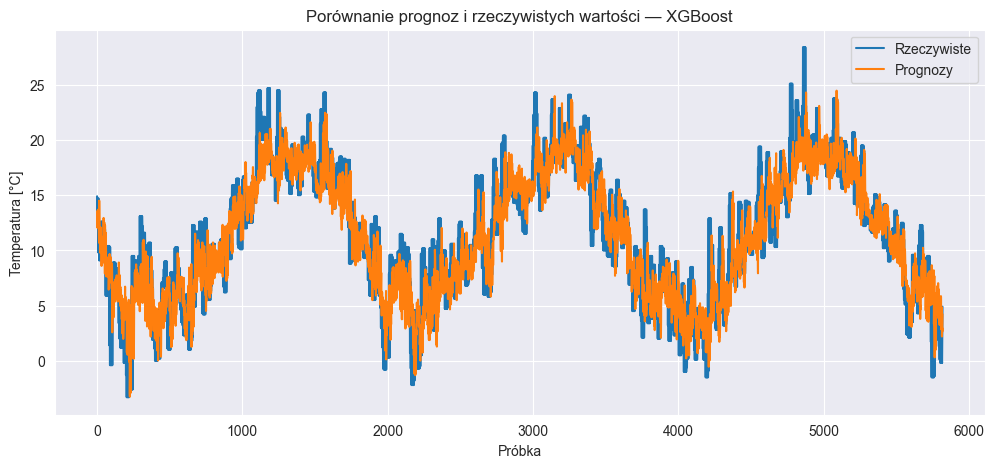

Prognoza 5 dni do przodu (XGBoost jednorazowo):
2026-01-10: 2.20 °C
2026-01-11: 2.79 °C
2026-01-12: 2.99 °C
2026-01-13: 2.65 °C
2026-01-14: 4.22 °C


In [12]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean.csv", parse_dates=["date"])
df_city = df[df['city'] == 'Warszawa'].copy()
df_city.sort_values("date", inplace=True)
df_city.reset_index(drop=True, inplace=True)

# =========================
# 2. Parametry
# =========================
WINDOW = 30       # liczba dni patrzonych wstecz
FORECAST = 5      # liczba dni do prognozy

# =========================
# 3. Tworzenie cech historycznych + sezonowych
# =========================
def create_features(df, window=WINDOW):
    X, y = [], []
    for i in range(window, len(df) - FORECAST + 1):
        hist = df['tavg'].iloc[i-window:i].values.tolist()
        dayofyear = df['date'].iloc[i].dayofyear
        month = df['date'].iloc[i].month
        last7 = df['tavg'].iloc[i-7:i].values
        avg7 = np.mean(last7)
        min7 = np.min(last7)
        max7 = np.max(last7)
        features = hist + [dayofyear, month, avg7, min7, max7]
        X.append(features)
        y.append(df['tavg'].iloc[i:i+FORECAST].values)
    return np.array(X), np.array(y)

X, y = create_features(df_city)

# =========================
# 4. Skalowanie
# =========================
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)  # multi-output (n_samples, 5)

# =========================
# 5. Train/test split
# =========================
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

# =========================
# 6. Trening MultiOutputRegressor (5 dni jednocześnie)
# =========================
xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)
model = MultiOutputRegressor(xgb)
model.fit(X_train, y_train)

# =========================
# 7. Predykcja na zbiorze testowym
# =========================
y_pred_scaled = model.predict(X_test)
y_test_rescaled = scaler_y.inverse_transform(y_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred_scaled)

# =========================
# 8. Metryki
# =========================
mse  = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2   = r2_score(y_test_rescaled, y_pred_rescaled)

print("XGBoost Multi-step Forecast — 5 dni")
print(f"R²   : {r2:.4f}")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")

# =========================
# 9. Wykres rzeczywiste vs prognozy
# =========================
plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled.flatten(), label='Rzeczywiste')
plt.plot(y_pred_rescaled.flatten(), label='Prognozy')
plt.title("Porównanie prognoz i rzeczywistych wartości — XGBoost")
plt.xlabel("Próbka")
plt.ylabel("Temperatura [°C]")
plt.legend()
plt.show()

# =========================
# 10. Prognoza 5 dni do przodu od ostatniego dnia w danych
# =========================
last_window = X_scaled[-1].reshape(1,-1)
future_scaled = model.predict(last_window)
future_pred = scaler_y.inverse_transform(future_scaled)

# =========================
# 11. Wypisanie prognoz
# =========================
print("Prognoza 5 dni do przodu (XGBoost jednorazowo):")
for i, pred in enumerate(future_pred.flatten(), 1):
    pred_date = df_city['date'].iloc[-1] + pd.Timedelta(days=i)
    print(f"{pred_date.date()}: {pred:.2f} °C")


00:48:41 - cmdstanpy - INFO - Chain [1] start processing
00:48:41 - cmdstanpy - INFO - Chain [1] done processing


Prognoza 5 dni do przodu (Prophet):
2026-01-15: -5.00 °C
2026-01-16: -4.75 °C
2026-01-17: -4.57 °C
2026-01-18: -4.02 °C
2026-01-19: -4.24 °C


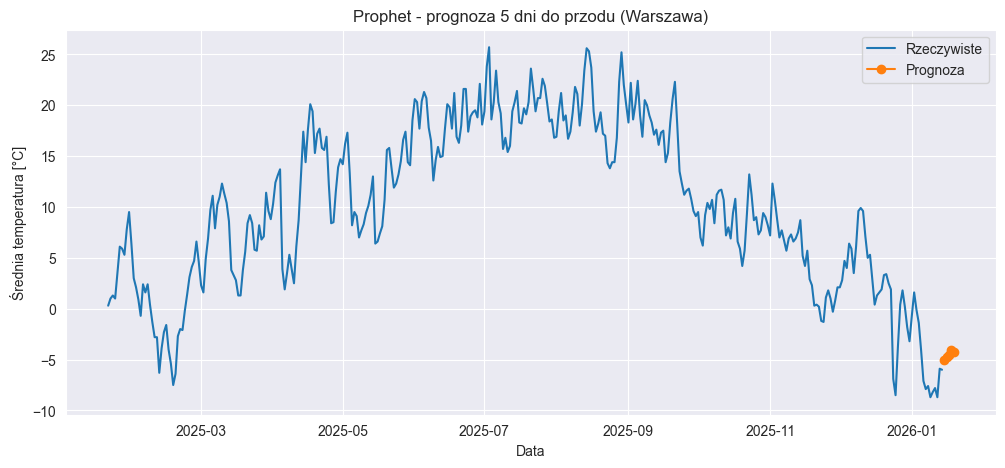

In [9]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean2.csv", parse_dates=["time"])
df_city = df[df['city'] == 'Warszawa'][['time','temp']].copy()
df_city.sort_values("time", inplace=True)
df_city.reset_index(drop=True, inplace=True)

# =========================
# 2. Przygotowanie danych do Prophet
# =========================
# Bierzemy ostatnie 180 dni, żeby model skupił się na krótkim okresie
df_recent = df_city[['time','temp']].tail(360).rename(columns={'time':'ds','temp':'y'})

# =========================
# 3. Budowa modelu Prophet
# =========================
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.8  # większa elastyczność trendu
)

# Trening modelu
model.fit(df_recent)

# =========================
# 4. Prognoza na 5 dni
# =========================
future = model.make_future_dataframe(periods=5)
forecast = model.predict(future)

# =========================
# 5. Wypisanie prognozy
# =========================
print("Prognoza 5 dni do przodu (Prophet):")
forecast_5days = forecast[['ds','yhat']].tail(5)
for idx, row in forecast_5days.iterrows():
    print(f"{row['ds'].date()}: {row['yhat']:.2f} °C")

# =========================
# 6. Wykres rzeczywiste vs prognozy
# =========================
plt.figure(figsize=(12,5))
plt.plot(df_recent['ds'], df_recent['y'], label='Rzeczywiste')
plt.plot(forecast_5days['ds'], forecast_5days['yhat'], label='Prognoza', marker='o')
plt.title("Prophet - prognoza 5 dni do przodu (Warszawa)")
plt.xlabel("Data")
plt.ylabel("Średnia temperatura [°C]")
plt.legend()
plt.grid(True)
plt.show()


02:40:37 - cmdstanpy - INFO - Chain [1] start processing
02:40:37 - cmdstanpy - INFO - Chain [1] done processing


Ostatnie 5 dni temperatury i prognoza 5 dni do przodu (Warszawa):
      Date Last5Days Forecast5Days
2026-01-05       0.1           NaN
2026-01-06      -0.2           NaN
2026-01-07       2.0           NaN
2026-01-08       3.2           NaN
2026-01-09       4.9           NaN
       NaT       NaN      3.956049
       NaT       NaN      4.803464
       NaT       NaN      6.143599
       NaT       NaN      7.970356
       NaT       NaN      9.871500


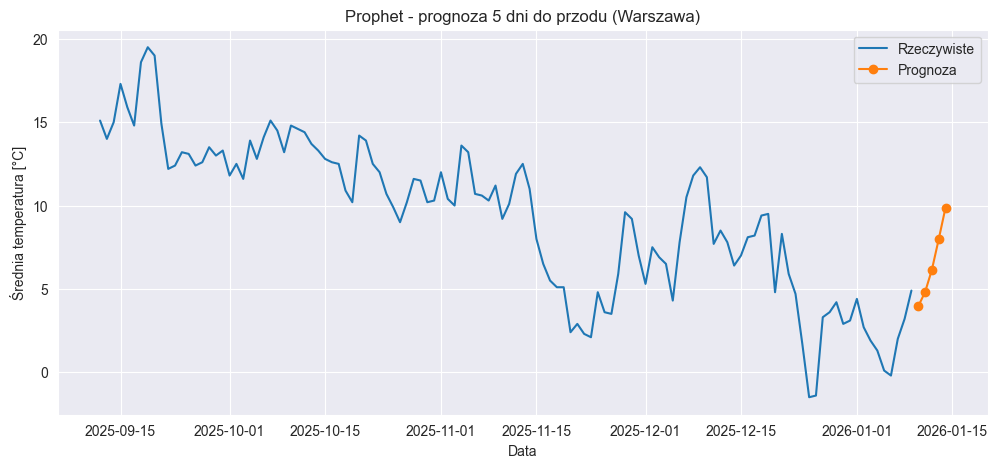

In [18]:
import os
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# =========================
# 1. Wczytanie danych
# =========================
os.chdir(r"C:\Users\gduls\PycharmProjects\suml")
df = pd.read_csv("european_capitals_history_clean.csv", parse_dates=["date"])
df_city = df[df['city'] == 'Warszawa'].copy()
df_city.sort_values("date", inplace=True)
df_city.reset_index(drop=True, inplace=True)

# =========================
# 2. Przygotowanie danych do Prophet
# =========================
# Bierzemy ostatnie 120 dni
df_recent = df_city[['date','tavg']].tail(120).rename(columns={'date':'ds','tavg':'y'})

# Duplikujemy ostatnie 60 dni, żeby model bardziej się skupił na ostatnich trendach
df_recent_focus = pd.concat([df_recent, df_recent.tail(60)], ignore_index=True)

# =========================
# 3. Budowa modelu Prophet
# =========================
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.5  # większa elastyczność trendu
)

model.fit(df_recent_focus)

# =========================
# 4. Prognoza na 5 dni
# =========================
future = model.make_future_dataframe(periods=5)
forecast = model.predict(future)

# =========================
# 5. Ostatnie 5 dni i prognoza 5 dni w jednej tabelce
# =========================
last_5_days = df_recent[['ds','y']].tail(5).copy()
forecast_5days = forecast[['ds','yhat']].tail(5).copy()
forecast_5days = forecast_5days.rename(columns={'yhat':'Predicted'})

combined = pd.concat([last_5_days.reset_index(drop=True), forecast_5days['Predicted']], axis=1)
print("Ostatnie 5 dni temperatury i prognoza 5 dni do przodu (Warszawa):")
print(combined.to_string(index=False, 
                         header=['Date','Last5Days','Forecast5Days']))

# =========================
# 6. Wykres
# =========================
plt.figure(figsize=(12,5))
plt.plot(df_recent['ds'], df_recent['y'], label='Rzeczywiste')
plt.plot(forecast_5days['ds'], forecast_5days['Predicted'], label='Prognoza', marker='o')
plt.title("Prophet - prognoza 5 dni do przodu (Warszawa)")
plt.xlabel("Data")
plt.ylabel("Średnia temperatura [°C]")
plt.legend()
plt.grid(True)
plt.show()
